In [98]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np
import pandas as pd

# =========================
# Load data (from Subgoal 2 outputs)
# =========================
train_df = pd.read_csv("../../data/training_data.csv")
test_df  = pd.read_csv("../../data/test_data.csv")

# =========================
# Target & Features
# =========================
TARGET = "Close_Price_Normalized"   # <-- comes from Subgoal 2
DROP_COLS = ["Date", "Close_Price"]

X_train = train_df.drop(columns=DROP_COLS + [TARGET])
y_train = train_df[TARGET]

X_test  = test_df.drop(columns=DROP_COLS + [TARGET])
y_test  = test_df[TARGET]

# =========================
# Feature Engineering
# =========================
for df_ in [X_train, X_test]:
    df_["Price_Range"] = df_["High_Price"] - df_["Low_Price"]
    df_["Return_Volatility"] = df_["Daily_Return_Pct"] * df_["Volatility_Range"]
    df_["Volume_Impact"] = df_["Volume"] * df_["Daily_Return_Pct"]

# =========================
# Final Matrices
# =========================
print("Final input dimension:", X_train.shape[1])


Final input dimension: 15


In [3]:
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

In [4]:
# Ensure all features are numeric
X_train_ols = X_train_ols.astype(np.float64)
X_test_ols  = X_test_ols.astype(np.float64)

y_train     = y_train.astype(np.float64)
y_test      = y_test.astype(np.float64)

In [5]:
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())

                              OLS Regression Results                              
Dep. Variable:     Close_Price_Normalized   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 3.918e+06
Date:                    Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                            20:14:29   Log-Likelihood:                 94427.
No. Observations:                   24000   AIC:                        -1.888e+05
Df Residuals:                       23985   BIC:                        -1.887e+05
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [6]:
ols_model.save("currentOlsSolution.pkl")


In [7]:
# =========================
# Predictions & Metrics
# =========================

y_pred = ols_model.predict(X_test_ols)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"OLS RMSE: {rmse:.6f}")
print(f"OLS R²:   {r2:.6f}")


OLS RMSE: 0.004719
OLS R²:   0.999568


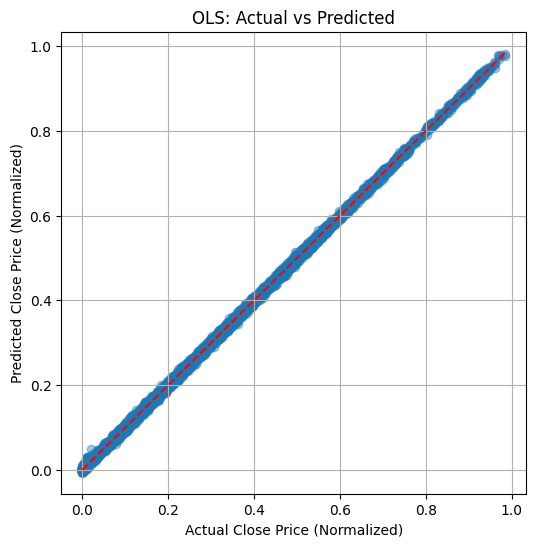

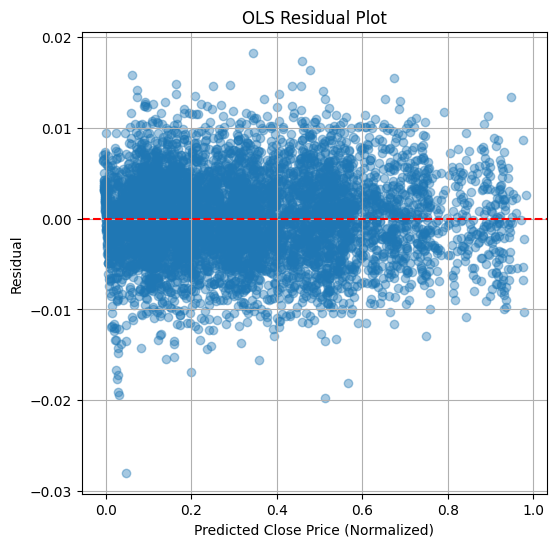

In [8]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Close Price (Normalized)")
plt.ylabel("Predicted Close Price (Normalized)")
plt.title("OLS: Actual vs Predicted")
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Close Price (Normalized)")
plt.ylabel("Residual")
plt.title("OLS Residual Plot")
plt.grid(True)
plt.show()


In [9]:
print(train_df.columns)


Index(['Date', 'Open_Price', 'Close_Price', 'High_Price', 'Low_Price',
       'Volume', 'Daily_Return_Pct', 'Volatility_Range', 'VIX_Close',
       'Economic_News_Flag', 'Sentiment_Score', 'Federal_Rate_Change_Flag',
       'GeoPolitical_Risk_Score', 'Currency_Index', 'Close_Price_Normalized'],
      dtype='object')


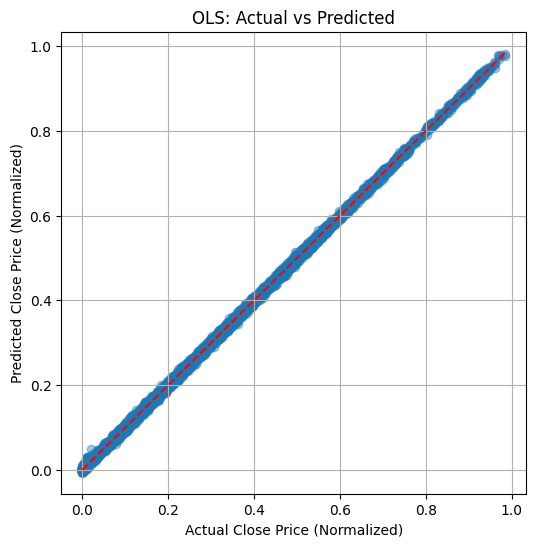

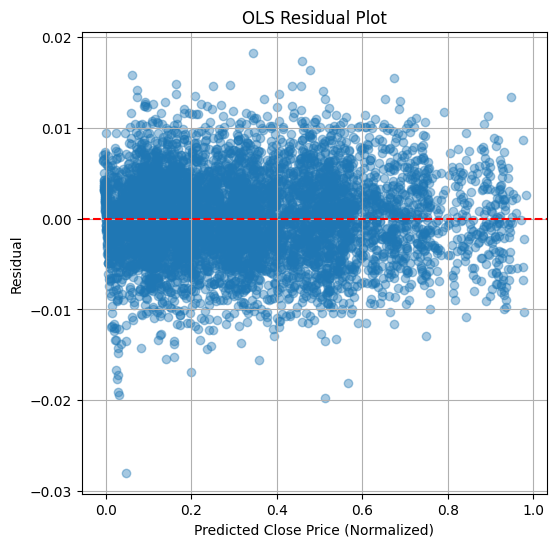

In [10]:
import os
import matplotlib.pyplot as plt

# =========================
# Output directory
# =========================
output_dir = "../../documentation/"
os.makedirs(output_dir, exist_ok=True)

# =========================
# Actual vs Predicted Plot
# =========================
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("Actual Close Price (Normalized)")
plt.ylabel("Predicted Close Price (Normalized)")
plt.title("OLS: Actual vs Predicted")
plt.grid(True)

plt.savefig(
    os.path.join(output_dir, "ols_actual_vs_predicted.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# =========================
# Residual Plot
# =========================
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Close Price (Normalized)")
plt.ylabel("Residual")
plt.title("OLS Residual Plot")
plt.grid(True)

plt.savefig(
    os.path.join(output_dir, "ols_residual_plot.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

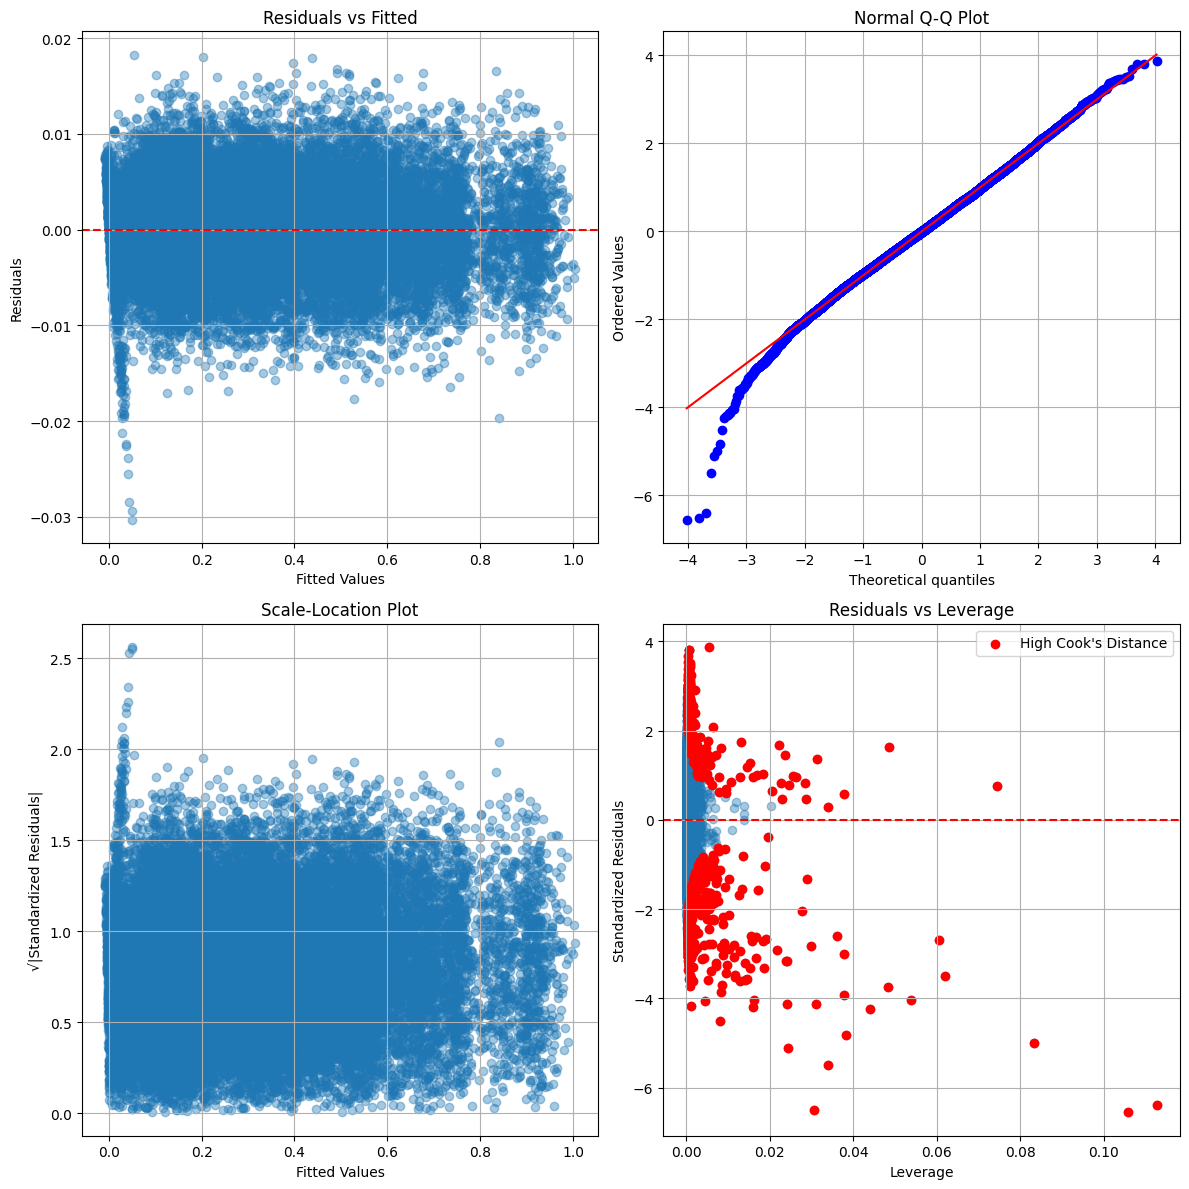

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# =========================
# Output directory
# =========================
output_dir = "../../documentation/"
os.makedirs(output_dir, exist_ok=True)

# =========================
# Diagnostics data
# =========================
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

influence = ols_model.get_influence()
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

# =========================
# Create 2x2 diagnostic figure
# =========================
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# ---- 1. Residuals vs Fitted ----
axes[0, 0].scatter(fitted_vals, residuals, alpha=0.4)
axes[0, 0].axhline(0, color="red", linestyle="--")
axes[0, 0].set_title("Residuals vs Fitted")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].grid(True)

# ---- 2. Normal Q-Q Plot ----
stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot")
axes[0, 1].grid(True)

# ---- 3. Scale-Location Plot ----
axes[1, 0].scatter(
    fitted_vals,
    np.sqrt(np.abs(standardized_residuals)),
    alpha=0.4
)
axes[1, 0].set_title("Scale-Location Plot")
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("√|Standardized Residuals|")
axes[1, 0].grid(True)

# ---- 4. Residuals vs Leverage ----
axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.4)
axes[1, 1].axhline(0, color="red", linestyle="--")

cook_threshold = 4 / len(X_train_ols)
high_cook = cooks > cook_threshold

axes[1, 1].scatter(
    leverage[high_cook],
    standardized_residuals[high_cook],
    color="red",
    label="High Cook's Distance"
)

axes[1, 1].set_title("Residuals vs Leverage")
axes[1, 1].set_xlabel("Leverage")
axes[1, 1].set_ylabel("Standardized Residuals")
axes[1, 1].legend()
axes[1, 1].grid(True)

# =========================
# Save combined image
# =========================
plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "ols_diagnostic_plots_combined.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()